# Ads for the apartments sales

Given the data of the Yandex.Realty service - an archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years. We need to learn how to determine the market value of real estate and set the parameters.

Two types of data are available for each apartment for sale. The first ones are entered by the user, the second ones are obtained automatically on the basis of cartographic data. For example, the distance to the center, airport, nearest park and reservoir.

In [1]:
import pandas as pd
import numpy as np
from datetime import date

In [3]:
# Загрузка данных из файла в датафрейм.
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

In [4]:

data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
# Общая информация из датасета.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<function matplotlib.pyplot.show(close=None, block=None)>

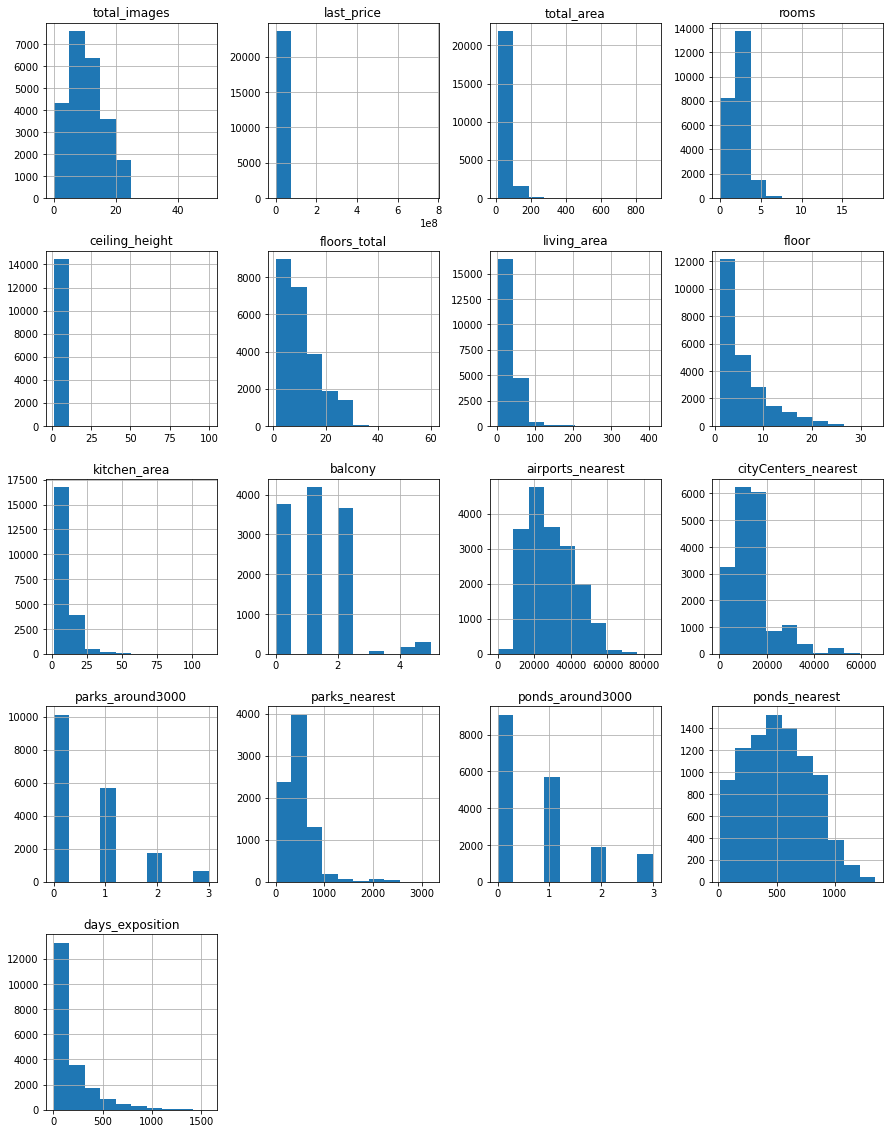

In [6]:
# Построение гистограммы для столбцов датафрейма.
data.hist(figsize = (15, 20))
plt.show

### Data preparation

In [7]:
# Подсчёт количества пропусков в таблице

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

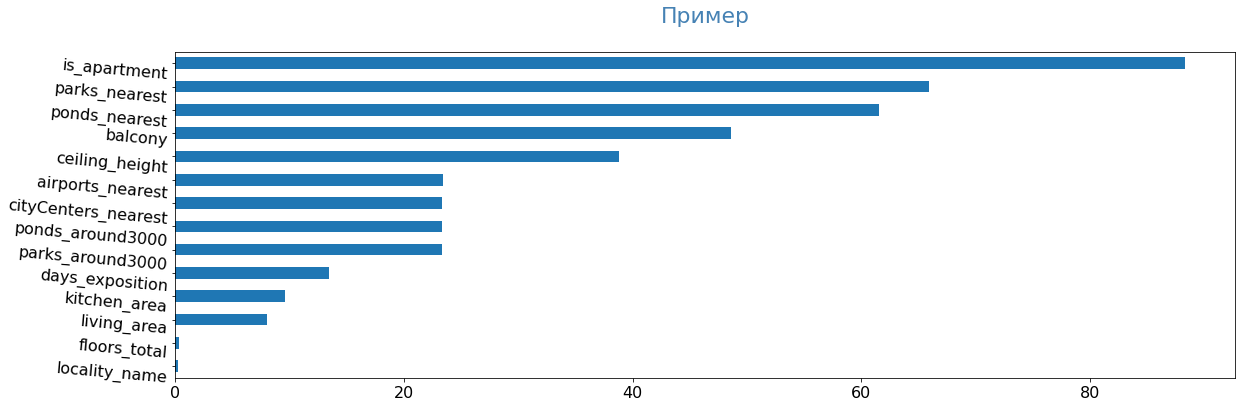

In [9]:
pass_value_barh(data)

In [10]:
# Заполнение пропусков

data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data = data.dropna(subset = ['floors_total', 'locality_name'])
#data['days_exposition'] = data['days_exposition'].fillna(0)

<b><u>Reason for skipping data:</u></b>

The column with the values is_apartment has the most gaps: here, the gaps can be interpreted as an object that is not an apartment (since it is a boolean variable).
The next columns are parks_nearest and ponds_nearest, the reason may be because the data is not updated: new buildings or work on parks and ponds. Likewise, the need to measure/count data such as number of floors, living area or kitchen area, where the same data may not be updated.

In [11]:
# Преобразование типов данных:

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['is_apartment'] = pd.to_numeric(data['is_apartment'])

#data['balcony'] = data['balcony'].astype(int)
#data['parks_around3000'] = data['parks_around3000'].astype(int)
#data['ponds_around3000'] = data['ponds_around3000'].astype(int)
#data['days_exposition'] = data['days_exposition'].astype(int)


for col in ['balcony', 'parks_around3000', 'ponds_around3000', 'floors_total']:
    data[col] = data[col].astype(int)
    

In [12]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,0,...,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,0,...,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,0,...,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,NaN,9,0,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,0,...,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0


<b><u>Why change the data type?</u></b>

The first_day_exposition column is not readable, it was necessary to remove the separator, as well as hours, minutes and seconds, since the time in the data is exactly midnight.
The is_apartment column has been converted to an int type, which is an alternative to a boolean type.
The columns balcony, parks_around3000, ponds_around3000, days_exposition were of type float and were converted to int because they describe the number of objects.

In [13]:
# Уникальные значения 
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [14]:
# Устранение дубликатов

data['locality_name'] = data['locality_name'].str.replace('посёлок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок', regex=True)

In [15]:
data = data.drop_duplicates().reset_index(drop = True)

In [16]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское

In [17]:
# Устранение аномальных значений
data['is_apartment'] = np.where(data['floor'] > 5, 1, 0)
data['rooms'] = np.where(data['rooms'] < 1, 1, data['rooms'])
data['ceiling_height'] = np.where(data['ceiling_height'] > 10, (data['ceiling_height'] / 10), data['ceiling_height'])
data['ceiling_height'] = np.where(data['ceiling_height'] < 2.5, 2.5, data['ceiling_height'])
data['floors_total'] = np.where(data['floors_total'] >= 37, 1, data['floors_total'])
data = data.loc[data['total_area'] < 700]

In [18]:
data['airports_nearest'] = data['airports_nearest'].fillna(data.groupby('locality_name')['airports_nearest'].median())

In [19]:
data['airports_nearest'].isna().count()

23564

<b><u>Reason for removing anomalous values</u></b>

1. If the dwelling consists of more than 5 floors, we assume that it is an apartment.
2. If there are fewer rooms in the dwelling than 1, it is assumed that this is an error. Entering data - 1 room.
3. If the ceiling is higher than 10m, it is assumed that this is an error. Data is entered that the ceiling is 10 times lower.
4. If the ceiling is lower than 2.5 m, it is assumed that this is an error. The ceiling height is regulated by SNiPs (Building Norms and Rules of the Russian Federation) and the minimum value is 2.5 m. Accordingly, ceilings with a height less than this norm become 2.5 m.
5. If the number of floors is more than 37, it is assumed that this is an error, since the tallest building in St. Petersburg has exactly 37 floors. It is important to note that during the inspection it was found that buildings with more than 37 storeys have only 2 rooms, which allows us to assume that these are one-story buildings.
6. If the distance between the accommodation and the nearest airport is less than 5000m, we assume that it is an error. There is a "Noise Radius Zone", which is exactly 5000 m, within the radius of which buildings cannot be located. We assign the values ​​​​below, a distance of 5000 m.
7. An apartment with an area of ​​900 sq.m. seems rather anomalous. and located on the 25th of 25 floors. It was decided to remove this apartment from the sample.

In [20]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23564 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23564 non-null  int64         
 1   last_price            23564 non-null  float64       
 2   total_area            23564 non-null  float64       
 3   first_day_exposition  23564 non-null  datetime64[ns]
 4   rooms                 23564 non-null  int64         
 5   ceiling_height        14480 non-null  float64       
 6   floors_total          23564 non-null  int64         
 7   living_area           21699 non-null  float64       
 8   floor                 23564 non-null  int64         
 9   is_apartment          23564 non-null  int64         
 10  studio                23564 non-null  bool          
 11  open_plan             23564 non-null  bool          
 12  kitchen_area          21342 non-null  float64       
 13  balcony         

We will fill rooms with the median value based on total_area.

In [21]:

data['rooms'].fillna(data.groupby('rooms')['total_area'].median())


0        3
1        1
2        2
3        3
4        2
        ..
23560    3
23561    3
23562    2
23563    2
23564    1
Name: rooms, Length: 23564, dtype: int64

In [23]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8198
2,7897
3,5779
4,1172
5,325
6,104
7,59
8,12
9,8
10,3


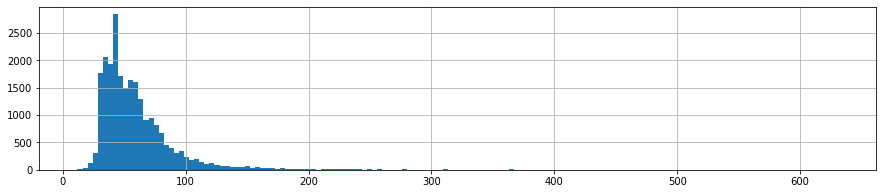

In [24]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

All apartments over two hundred square meters can be considered rarities, this is especially noticeable in the second graph, where we examine in detail the gap from 180 square meters. meters up to 500.

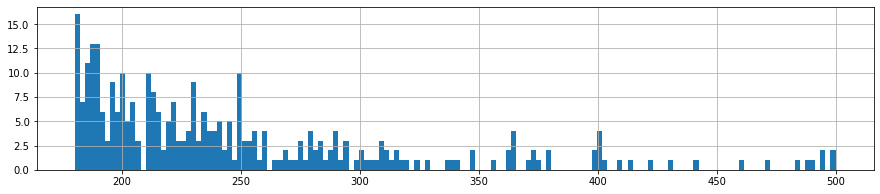

In [25]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [26]:
data = data.loc[data['total_area'] < 200]

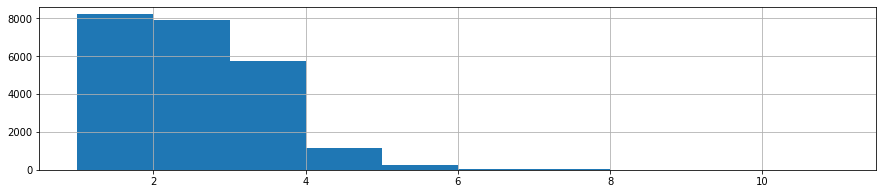

In [27]:
data.rooms.hist(bins = 10, figsize = (15,3));

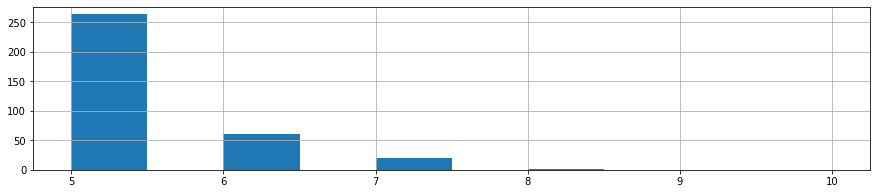

In [28]:
#check
data.rooms.hist(bins = 10, figsize = (15,3), range = (5,10));

In [29]:
data.loc[data['living_area'].isna(), 'living_area'] = data['living_area'].median()

<AxesSubplot:>

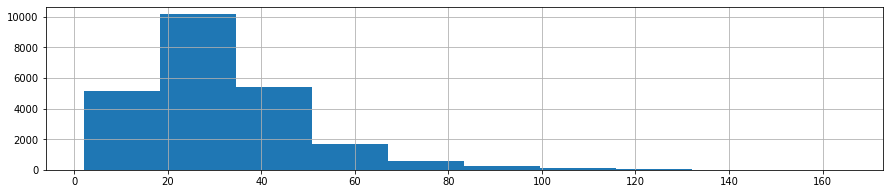

In [30]:
data.living_area.hist(figsize = (15, 3))

<AxesSubplot:>

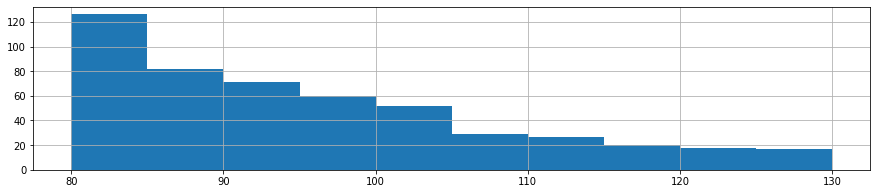

In [31]:
data.living_area.hist(figsize = (15, 3), range = (80, 130))

<AxesSubplot:>

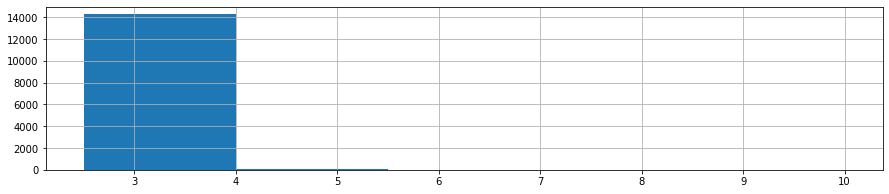

In [32]:
data.ceiling_height.hist(bins = 5, figsize = (15, 3))

Ceilings below 2 and above 4 m are considered rare. In the next step, we will get rid of these values.

<AxesSubplot:>

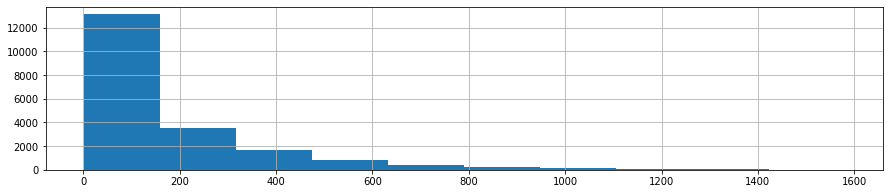

In [33]:
data.days_exposition.hist(figsize = (15, 3))

In [34]:
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].median()

<AxesSubplot:>

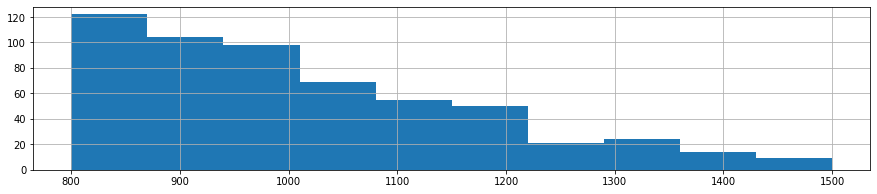

In [35]:
data.days_exposition.hist(figsize = (15, 3), range = (800, 1500))

<AxesSubplot:>

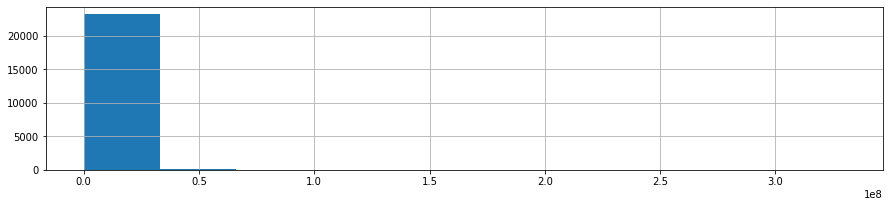

In [36]:
data.last_price.hist(figsize = (15, 3))

<AxesSubplot:>

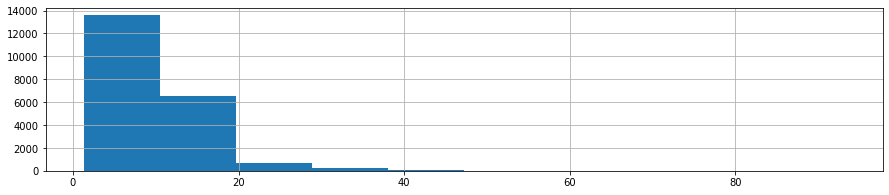

In [37]:
data.kitchen_area.hist(figsize = (15, 3))

<AxesSubplot:>

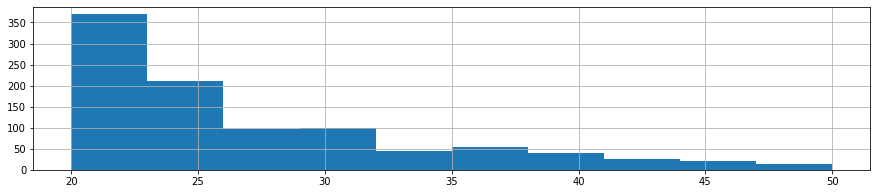

In [38]:
data.kitchen_area.hist(figsize = (15, 3), range = (20, 50))

In [39]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,335.00","23,335.00","14,333.00","23,335.00","23,335.00","23,335.00","21,143.00","23,335.00","23,335.00"
min,1.00,12.00,2.50,1.00,"12,190.00",2.00,1.30,1.00,1.00
max,11.00,199.20,10.00,"1,580.00","330,000,000.00",164.70,93.20,33.00,36.00


We can say that rooms above 5 are considered rare.
Accordingly, we apply filtering.

### Additional columns to the table

In [40]:
# цена одного квадратного метра
data['price_psm'] = round(data['last_price'] / data['total_area'], 1)

# день недели публикации объявления
#dt = data['day']
data['day'] = data['first_day_exposition'].apply(date.isoweekday)

# месяц публикации объявления
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

# год публикации объявления
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

# тип этажа квартиры
def flooring(df):
    if df['floor'] == 1:
        return "первый"
    elif df['floor'] == df['floors_total']:
        return 'последний'
    elif df['floor'] == 0:
        return "нулевой"
    else:
        return 'другой'
data['floor_type'] = data.apply(flooring, axis = 1)

# расстояние до центра города в километрах 
data['city_center'] = round(data['cityCenters_nearest'] / 1000)

In [41]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_psm,day,month,year,floor_type,city_center
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,1,...,482.0,2,755.0,95.0,120370.4,4,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,0,...,NaN,0,NaN,81.0,82920.8,2,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,0,...,90.0,2,574.0,558.0,92785.7,4,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.0,9,1,...,84.0,3,234.0,424.0,408176.1,5,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,1,...,112.0,1,48.0,121.0,100000.0,2,6,2018,другой,8.0


In [42]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.28,2.50,4.00,"1,000,000.00",13.02,5.00,1.00,2.00
0.5,2.00,51.70,2.65,95.00,"4,600,000.00",30.00,9.00,4.00,9.00
0.9,3.00,91.00,3.00,423.00,"10,500,000.00",52.60,15.30,13.00,22.00
0.9976,6.00,185.00,4.12,"1,278.00","49,899,360.00",118.50,45.00,25.00,27.00


### Exploratory data analysis

In [43]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,kitchen_area,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_psm,day,month,year,city_center
count,23335.000000,2.333500e+04,23335.000000,23335.000000,14333.000000,23335.000000,23335.000000,23335.000000,23335.000000,21143.000000,...,23335.000000,7879.000000,23335.000000,8873.000000,23335.000000,2.333500e+04,23335.000000,23335.000000,23335.000000,17838.000000
mean,9.852925,6.019566e+06,58.126632,2.042468,2.721832,10.711549,32.983158,5.888194,0.376302,10.375369,...,0.461324,491.788933,0.582730,520.300687,168.241868,9.841161e+04,3.565974,6.402228,2017.374759,14.275255
std,5.666245,6.236070e+06,26.449663,0.982292,0.285335,6.588589,16.673742,4.880808,0.484468,5.360675,...,0.740033,342.308635,0.878542,277.870279,205.226562,4.573445e+04,1.789206,3.492444,1.035119,8.606106
min,0.000000,1.219000e+04,12.000000,1.000000,2.500000,1.000000,2.000000,1.000000,0.000000,1.300000,...,0.000000,1.000000,0.000000,13.000000,1.000000,1.118000e+02,1.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.500000,5.000000,19.000000,2.000000,0.000000,7.000000,...,0.000000,288.000000,0.000000,296.000000,45.000000,7.648760e+04,2.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,51.700000,2.000000,2.650000,9.000000,30.000000,4.000000,0.000000,9.000000,...,0.000000,456.000000,0.000000,505.000000,95.000000,9.485370e+04,4.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.699500e+06,68.760000,3.000000,2.800000,16.000000,40.910000,8.000000,1.000000,11.950000,...,1.000000,613.000000,1.000000,733.000000,197.000000,1.138650e+05,5.000000,10.000000,2018.000000,16.000000
max,50.000000,3.300000e+08,199.200000,11.000000,10.000000,36.000000,164.700000,33.000000,1.000000,93.200000,...,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.736842e+06,7.000000,12.000000,2019.000000,66.000000


#### Object parameters

##### <u>Total area</u>

Text(0, 0.5, 'Квартиры')

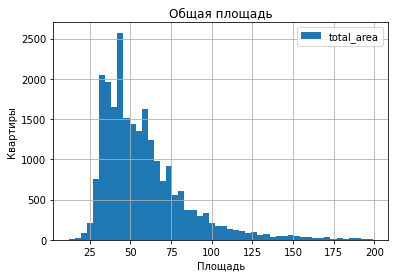

In [44]:
#общая площадь

data.plot(y = 'total_area', kind = 'hist', title = 'Общая площадь', grid = True, bins = 50)
plt.xlabel('Площадь')
plt.ylabel('Квартиры')

The peak falls on the area of ​​an apartment with a size of 50 - 60 sq.m. Values above 200 sq.m. reduced to zero. We build a range diagram to find normal values. As you can see in the boxplot(), values above 70 (as also shown in the describe() method table above) are outliers.

Text(0.5, 1.0, 'Диаграмма размаха значений площади')

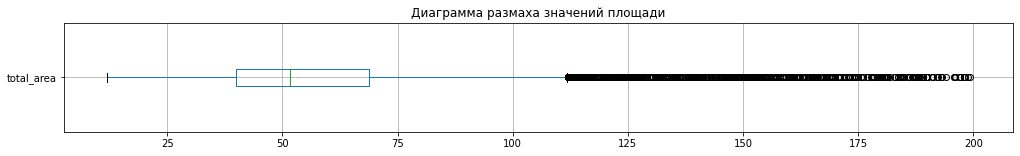

In [45]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
#ax.set_xlim(0, 400);

In [46]:
(
    data[['total_area']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,total_area
count,"23,335.00"
min,12.00
max,199.20


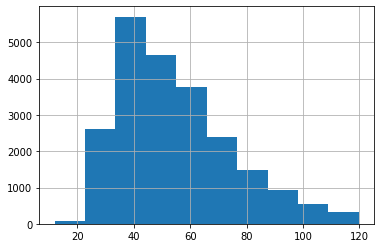

In [47]:
data.query('total_area < 120 and total_area > 10')['total_area'].hist()
plt.show()

##### <u>Living area</u>

We will carry out similar work for the rest of the graphs: we will build a histogram and a range diagram, find outlier regions and normalize the data.

Text(0, 0.5, 'Квартиры')

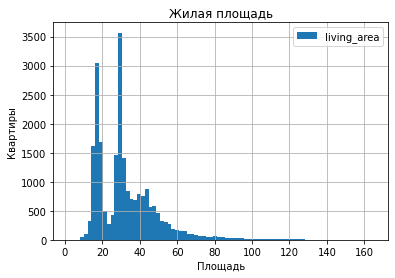

In [48]:
data.plot(y = 'living_area', kind = 'hist', title = 'Жилая площадь', grid = True, bins = 80)
plt.xlabel('Площадь')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха значений площади')

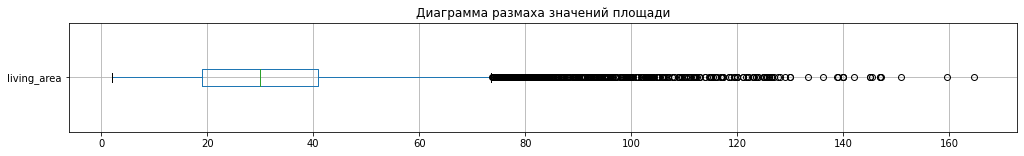

In [49]:

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')

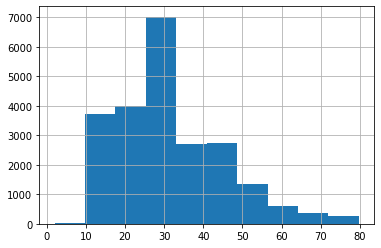

In [50]:
data.query('living_area < 80')['living_area'].hist()
plt.show()

Text(0.5, 1.0, 'Диаграмма размаха значений площади')

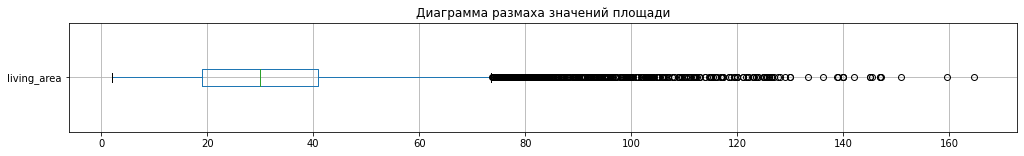

In [51]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')

We can say that these data are practically cleared of outliers. Get rid of the remaining emissions by setting the scope to 55 sq.m.

In [52]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23335 entries, 0 to 23564
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23335 non-null  int64         
 1   last_price            23335 non-null  float64       
 2   total_area            23335 non-null  float64       
 3   first_day_exposition  23335 non-null  datetime64[ns]
 4   rooms                 23335 non-null  int64         
 5   ceiling_height        14333 non-null  float64       
 6   floors_total          23335 non-null  int64         
 7   living_area           23335 non-null  float64       
 8   floor                 23335 non-null  int64         
 9   is_apartment          23335 non-null  int64         
 10  studio                23335 non-null  bool          
 11  open_plan             23335 non-null  bool          
 12  kitchen_area          21143 non-null  float64       
 13  balcony         

In [53]:
# check
data.shape[0]

23335

##### <u>Kitchen area</u>

Text(0, 0.5, 'Квартиры')

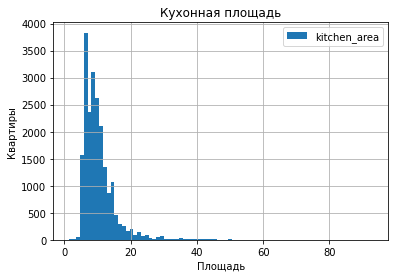

In [54]:
data.plot(y = 'kitchen_area', kind = 'hist', title = 'Кухонная площадь', grid = True, bins = 80)
plt.xlabel('Площадь')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха значений площади')

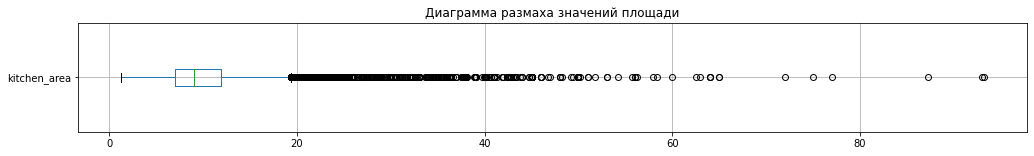

In [55]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')

Here we can see clear data spikes beyond 20 sq.m.

<AxesSubplot:>

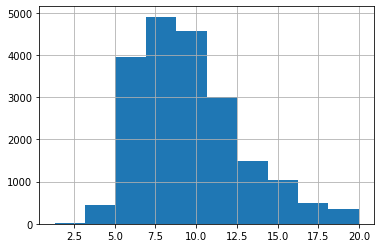

In [56]:
data.query('kitchen_area <= 20')['kitchen_area'].hist()

In [57]:
# check
data.shape[0]

23335

##### <u>Last price of apartment</u>

In [58]:
data['last_price'].describe()

count    2.333500e+04
mean     6.019566e+06
std      6.236070e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.600000e+06
75%      6.699500e+06
max      3.300000e+08
Name: last_price, dtype: float64

Text(0, 0.5, 'Квартиры')

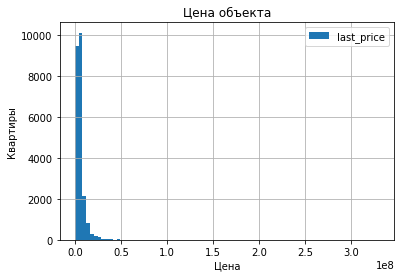

In [59]:
data.plot(y = 'last_price', kind = 'hist', title = 'Цена объекта', grid = True, bins = 80)
plt.xlabel('Цена')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха значений цены')

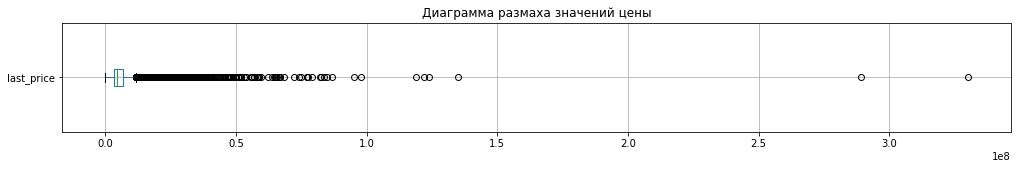

In [60]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений цены')

The value of the lower quartel = 0 seems extremely strange. At the same time, it is at least at 1.219000e+04. Accordingly, you need to find an apartment with an anomalous minimum value that shifts the quartile to zero.

In [61]:
data[data['last_price'] >= 1.219000e+04].sort_values(by = 'last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_psm,day,month,year,floor_type,city_center
8750,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,1,...,805.0,0,NaN,8.0,111.8,3,3,2019,последний,9.0
17359,7,430000.0,30.4,2019-04-22,1,NaN,2,16.0,1,0,...,NaN,0,NaN,95.0,14144.7,1,4,2019,первый,NaN
14825,5,430000.0,54.0,2018-06-26,2,NaN,3,30.0,3,0,...,NaN,0,NaN,44.0,7963.0,2,6,2018,последний,NaN
16185,18,440000.0,40.0,2018-07-10,1,NaN,5,30.0,1,0,...,NaN,0,NaN,45.0,11000.0,2,7,2018,первый,NaN
9535,7,450000.0,43.4,2018-08-31,2,NaN,5,30.3,3,0,...,NaN,0,NaN,96.0,10368.7,5,8,2018,другой,NaN
5670,7,450000.0,42.0,2017-07-31,2,NaN,1,23.0,1,0,...,NaN,0,NaN,233.0,10714.3,1,7,2017,первый,NaN
16130,14,450000.0,38.5,2018-07-11,2,2.65,2,30.0,1,0,...,NaN,0,NaN,45.0,11688.3,3,7,2018,первый,NaN
17577,0,450000.0,36.5,2018-02-01,1,NaN,5,17.3,4,0,...,NaN,0,NaN,120.0,12328.8,4,2,2018,другой,NaN
18763,1,470000.0,41.0,2018-02-11,1,NaN,5,32.0,3,0,...,NaN,0,NaN,46.0,11463.4,7,2,2018,другой,NaN
23352,11,470000.0,44.5,2018-07-02,2,NaN,2,28.0,2,0,...,NaN,0,NaN,298.0,10561.8,1,7,2018,последний,NaN


For a price of 12,190 rubles, you can get an apartment with an area of 109 square meters. m. The value is abnormal, Conclusion - get rid of this value.

In [62]:
data[data['last_price'] <= 6.499000e+07].sort_values(by = 'last_price', ascending = False).head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_psm,day,month,year,floor_type,city_center
23442,14,64990000.0,139.0,2015-11-24,3,3.0,8,3.00,8,1,...,630.0,3,100.0,280.0,467554.0,2,11,2015,последний,6.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.00,9,1,...,84.0,3,234.0,424.0,408176.1,5,7,2015,другой,7.0
19044,9,63900000.0,140.8,2017-07-13,3,3.3,6,74.30,4,0,...,295.0,3,190.0,103.0,453835.2,4,7,2017,другой,7.0
15416,7,62316000.0,173.1,2017-10-14,4,NaN,16,30.00,15,1,...,75.0,0,NaN,520.0,360000.0,6,10,2017,другой,5.0
9588,4,59534892.0,172.4,2016-04-02,4,3.0,8,91.24,5,0,...,128.0,1,481.0,95.0,345330.0,6,4,2016,другой,7.0
22581,20,59000000.0,127.5,2016-12-21,4,3.0,12,85.00,8,1,...,84.0,3,234.0,635.0,462745.1,3,12,2016,другой,7.0
12154,20,59000000.0,127.5,2017-01-24,4,3.0,12,85.00,8,1,...,84.0,3,234.0,5.0,462745.1,2,1,2017,другой,7.0
18769,15,58500000.0,187.5,2017-08-17,3,NaN,7,63.20,2,0,...,230.0,3,215.0,5.0,312000.0,4,8,2017,другой,6.0
21008,17,57906000.0,177.9,2016-06-11,4,NaN,8,99.21,4,0,...,164.0,2,473.0,212.0,325497.5,6,6,2016,другой,7.0
4373,20,57000000.0,174.0,2015-11-09,3,3.2,10,95.00,6,1,...,193.0,3,199.0,1039.0,327586.2,1,11,2015,другой,4.0


<AxesSubplot:>

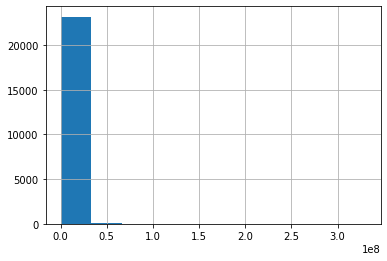

In [63]:
data.query('last_price >= 430000.0')['last_price'].hist()

In [64]:
norm = data.query('last_price >= 430000.0')

In [65]:
norm.shape[0]

23334

In [66]:
# check 
data.shape

(23335, 28)

##### <u>Number of rooms</u>

Text(0, 0.5, 'Квартиры')

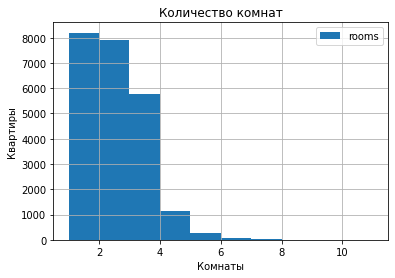

In [67]:
data.plot(y = 'rooms', kind = 'hist', title = 'Количество комнат', grid = True, bins = 10)
plt.xlabel('Комнаты')
plt.ylabel('Квартиры')

The peak falls on apartments with 2 rooms, less often on 3 and 4-room apartments. The number of rooms is a quantitative characteristic. Accordingly, a quantitative description diagram is not required in this case.

##### <u>Ceiling height</u>

In [68]:
data['ceiling_height'].describe()

count    14333.000000
mean         2.721832
std          0.285335
min          2.500000
25%          2.500000
50%          2.650000
75%          2.800000
max         10.000000
Name: ceiling_height, dtype: float64

In [69]:
data['ceiling_height'].isna().sum()

9002

Text(0, 0.5, 'Квартиры')

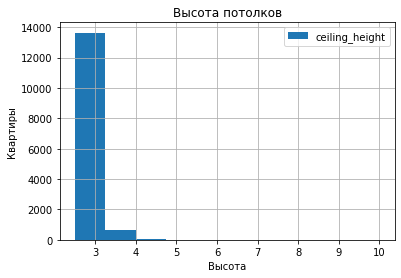

In [70]:
data.plot(y = 'ceiling_height', kind = 'hist', title = 'Высота потолков', grid = True, bins = 10)
plt.xlabel('Высота')
plt.ylabel('Квартиры')

(2.0, 5.0)

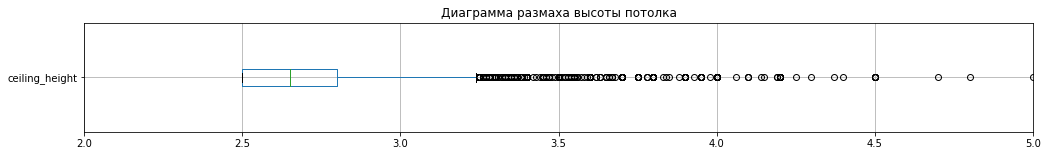

In [71]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['ceiling_height']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха высоты потолка')
plt.xlim(2, 5)

<AxesSubplot:>

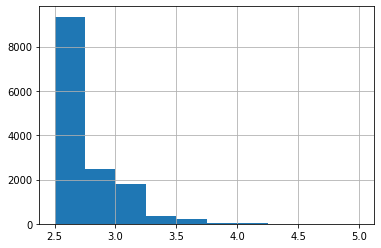

In [72]:
data.query('ceiling_height >= 2.5 and ceiling_height <= 5')['ceiling_height'].hist()

It is noteworthy that the strike of the lower interquartile range coincides with the first quartile.
It will be necessary to check the resulting diagram for an error.

In [74]:
data.query('ceiling_height >= 2.5 and ceiling_height <= 5').shape[0]

14324

In [75]:
# check
data.shape

(23335, 28)

Emissions fall on values with a height above 3m.

##### <u>Floor</u>

Text(0, 0.5, 'Квартиры')

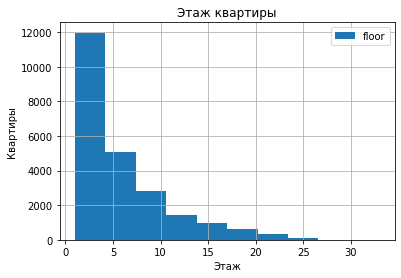

In [76]:
data.plot(y = 'floor', kind = 'hist', title = 'Этаж квартиры', grid = True, bins = 10)
plt.xlabel('Этаж')
plt.ylabel('Квартиры')

The peak of data falls on the 3rd-4th floor. As we can see, the data looks normalized.

##### <u>Total number of floors</u>

Text(0, 0.5, 'Квартиры')

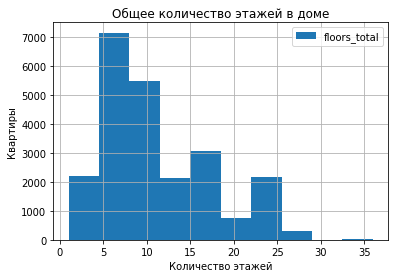

In [78]:
data.plot(y = 'floors_total', kind = 'hist', title = 'Общее количество этажей в доме', grid = True, bins = 10)
plt.xlabel('Количество этажей')
plt.ylabel('Квартиры')

The peak is observed at a number of storeys of 5-10 floors. The data is cleared of outliers.

##### <u>Distance to city centers</u>

Text(0, 0.5, 'Квартиры')

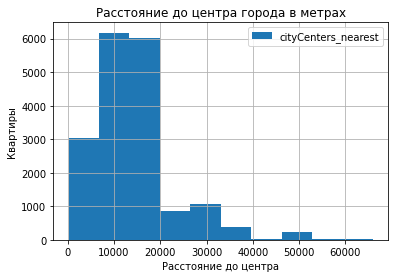

In [79]:
data.plot(y = 'cityCenters_nearest', kind = 'hist', title = 'Расстояние до центра города в метрах', grid = True, bins = 10)
plt.xlabel('Расстояние до центра')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха центров')

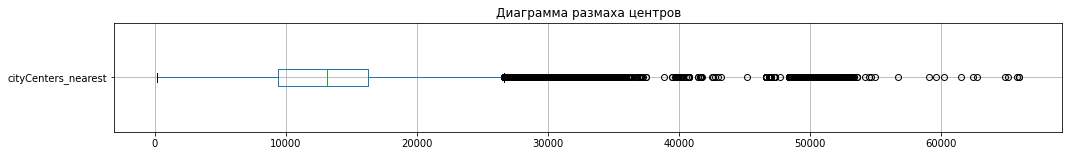

In [80]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['cityCenters_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха центров')

In this case, there are clear outliers for values above 25000 m and below 5000 m.

<AxesSubplot:>

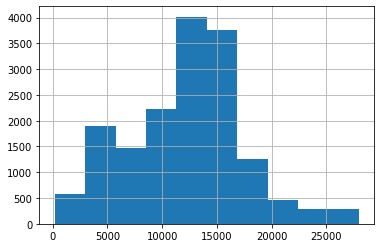

In [81]:
data.query('cityCenters_nearest <= 28000')['cityCenters_nearest'].hist()


In [82]:
# check
data.shape

(23335, 28)

##### <u>Distance to the nearest airport</u>

Text(0, 0.5, 'Квартиры')

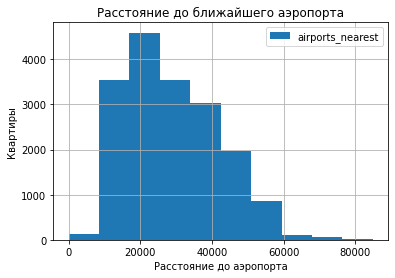

In [83]:
data.plot(y = 'airports_nearest', kind = 'hist', title = 'Расстояние до ближайшего аэропорта', grid = True, bins = 10)
plt.xlabel('Расстояние до аэропорта')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха расположения к аэропортам')

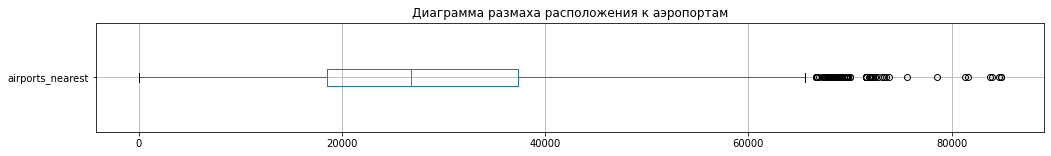

In [84]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['airports_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха расположения к аэропортам')

<AxesSubplot:>

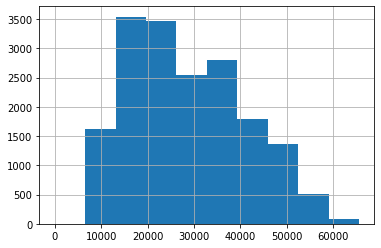

In [85]:
data.query('airports_nearest <= 66000')['airports_nearest'].hist()

Данные нормализованы. Пик приходится на расстояние в 15-30 км.

##### <u>Distance to the nearest park</u>

Text(0, 0.5, 'Квартиры')

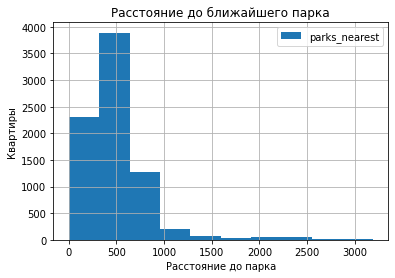

In [86]:
data.plot(y = 'parks_nearest', kind = 'hist', title = 'Расстояние до ближайшего парка', grid = True, bins = 10)
plt.xlabel('Расстояние до парка')
plt.ylabel('Квартиры')

Text(0.5, 1.0, 'Диаграмма размаха расположения к паркам')

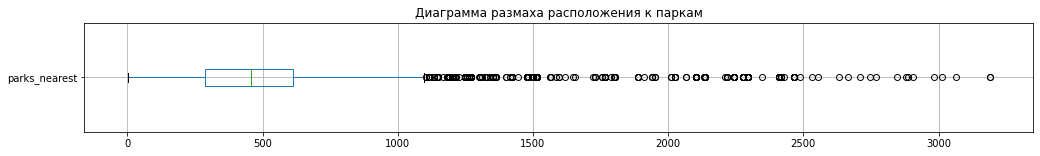

In [87]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['parks_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха расположения к паркам')

The data is dominated by outliers above 1200 m. The peak occurs at 500 - 600 m.

<AxesSubplot:>

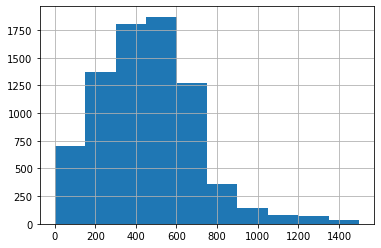

In [88]:
data.query('parks_nearest <= 1500')['parks_nearest'].hist()

In [89]:
# check
data.shape

(23335, 28)

##### <u> Date of publication</u>

Text(0, 0.5, 'Квартиры')

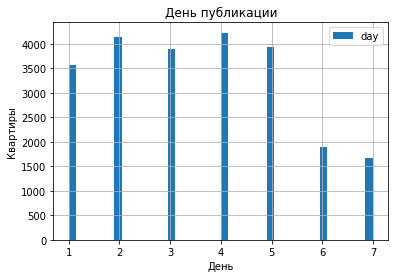

In [90]:
data.plot(y = 'day', kind = 'hist', title = 'День публикации', grid = True, bins = 40)
plt.xlabel('День')
plt.ylabel('Квартиры')

Text(0, 0.5, 'Квартиры')

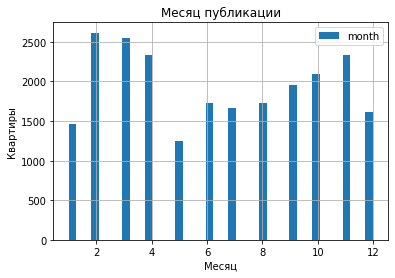

In [91]:
data.plot(y = 'month', kind = 'hist', title = 'Месяц публикации', grid = True, bins = 40)
plt.xlabel('Месяц')
plt.ylabel('Квартиры')

Peak posting days are Tuesday, Thursday and Friday. Peaks for publication months - February. Least of all announcements were placed in May.

#### Days of ad exposition

Text(0, 0.5, 'Квартиры')

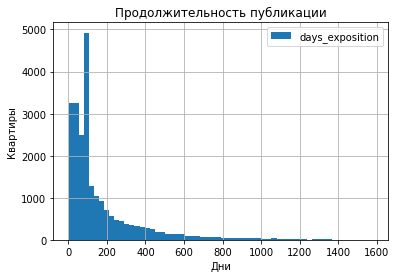

In [92]:
data.plot(y = 'days_exposition', kind = 'hist', title = 'Продолжительность публикации', grid = True, bins = 60)
plt.xlabel('Дни')
plt.ylabel('Квартиры')

The peak of values falls on 0-50 days, after that, the values decrease to the level of 1200-1400.

Calculate the mean with the mean() function and the median with median().

In [93]:
print(data['days_exposition'].mean())

168.24186843796872


In [94]:
print(data['days_exposition'].median())

95.0


Text(0.5, 1.0, 'Диаграмма размаха продаж квартир')

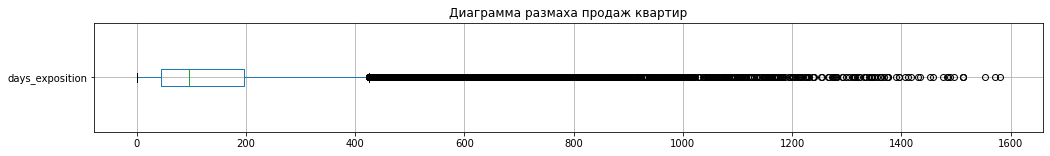

In [95]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха продаж квартир')

<AxesSubplot:>

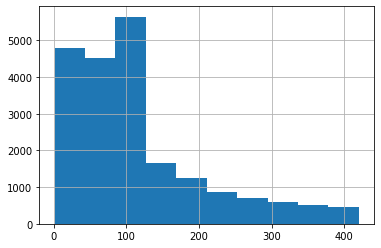

In [96]:
data.query('days_exposition <= 420')['days_exposition'].hist()

In [97]:
# check
data.shape

(23335, 28)

In [98]:
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

168.24186843796872
95.0


The main peak is at a duration of 50 days. A normal sale takes 46 days. Long can be considered sales from 50 days.

In [99]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23335 entries, 0 to 23564
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23335 non-null  int64         
 1   last_price            23335 non-null  float64       
 2   total_area            23335 non-null  float64       
 3   first_day_exposition  23335 non-null  datetime64[ns]
 4   rooms                 23335 non-null  int64         
 5   ceiling_height        14333 non-null  float64       
 6   floors_total          23335 non-null  int64         
 7   living_area           23335 non-null  float64       
 8   floor                 23335 non-null  int64         
 9   is_apartment          23335 non-null  int64         
 10  studio                23335 non-null  bool          
 11  open_plan             23335 non-null  bool          
 12  kitchen_area          21143 non-null  float64       
 13  balcony         

#### Factors affecting the total cost of an object.

##### <u>Total area</u>

In [100]:
print(round(data['last_price'].corr(data['total_area']), 2))

0.66


The correlation between price and area is positive, that is, directly proportional - with an increase in area, an increase in prices is observed.
Let's plot it on a scatter plot - scatter plot()

Text(0, 0.5, 'Площадь')

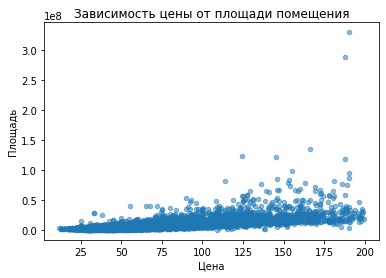

In [101]:
data.plot(x = 'total_area', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от площади помещения', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Площадь')

##### <u>Living area</u>

In [102]:
print(round(data['last_price'].corr(data['living_area']), 2))

0.52


Here, we can notice a lower correlation between living space and price, as opposed to total area. At the same time, the correlation remains positive, which means direct proportionality.

Text(0, 0.5, 'Жилая Площадь')

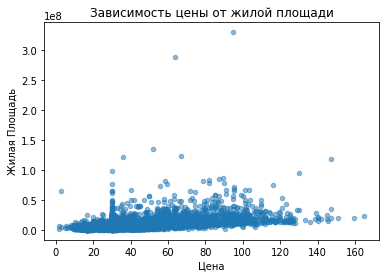

In [103]:
data.plot(x = 'living_area', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от жилой площади', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Жилая Площадь')

##### <u>Kitchen area</u>

In [104]:
print(round(data['last_price'].corr(data['kitchen_area']), 2))

0.52


The correlation is even lower than the previous parameters. This means that the area of the kitchen has less influence on the overall price than the total or living area.

Text(0, 0.5, 'Площадь Кухни')

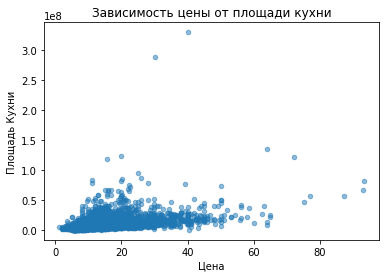

In [105]:
data.plot(x = 'kitchen_area', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от площади кухни', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Площадь Кухни')

##### <u>Number of rooms</u>

In [106]:
print(round(data['last_price'].corr(data['rooms']), 2))

0.38


The correlation continues to decrease towards zero, which means that the parameter has no effect on the price.

Text(0, 0.5, 'Количество комнат')

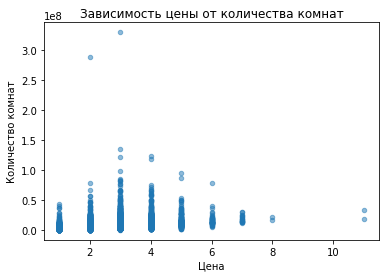

In [107]:
data.plot(x = 'rooms', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от количества комнат', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Количество комнат')

On the graph, you can see that with an increase in the number of rooms, the price remains the same - a constant, which is characterized by a correlation close to zero.

##### <u>Floor</u>

In [108]:
print(round(data['last_price'].corr(data['floor']), 2))

0.04


Text(0, 0.5, 'Этаж')

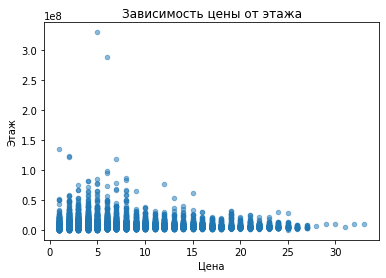

In [109]:
data.plot(x = 'floor', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от этажа', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Этаж')

Likewise, the correlation is low. We can say that the floor does not affect the price.

##### <u>Date of publication</u>

In [110]:
print(round(data['last_price'].corr(data['day']), 2))

-0.01


The correlation has a negative value, but at the same time it is critically minimal. Accordingly, it cannot be said that the day has an impact on the price.

Text(0, 0.5, 'День')

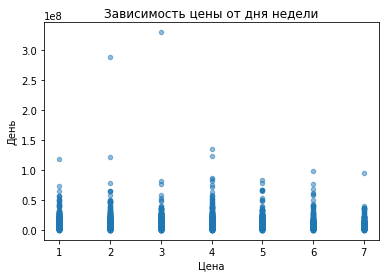

In [111]:
data.plot(x = 'day', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от дня недели', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('День')

In [112]:
print(round(data['last_price'].corr(data['month']), 2))

0.0


Correlation = 0. We neglect the influence of the placement month.

Text(0, 0.5, 'Месяц')

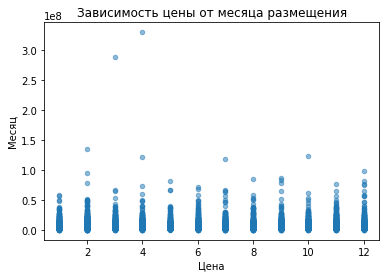

In [113]:
data.plot(x = 'month', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от месяца размещения', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Месяц')

In [114]:
print(round(data['last_price'].corr(data['year']), 2))

-0.04


Text(0, 0.5, 'Год')

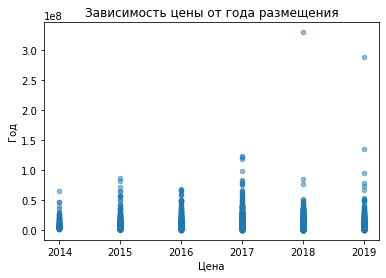

In [115]:
data.plot(x = 'year', y = 'last_price', kind = 'scatter', title = 'Зависимость цены от года размещения', alpha = 0.5)
plt.xlabel('Цена')
plt.ylabel('Год')

We also neglect the correlation value.

#### The average price of one square meter in 10 settlements with the largest number of ads.

In [116]:
avg = data.groupby('locality_name')['price_psm'].agg(['mean', 'count']).sort_values(by = 'count', ascending = False).head(10)
display(avg)

,mean,count
locality_name,,
Санкт-Петербург,113562.973005,15436
поселок Мурино,85629.567754,552
поселок Шушары,78551.343964,439
Всеволожск,68654.475628,398
Пушкин,103122.537363,364
Колпино,75333.298516,337
поселок Парголово,90332.264724,326
Гатчина,68746.147231,307
деревня Кудрово,92473.546488,299


In [117]:
print(avg['mean'].mean())

83454.80618454255


In [118]:
print(avg.sort_values(by = 'mean', ascending = False).head(1))

                          mean  count
locality_name                        
Санкт-Петербург  113562.973005  15436


In [119]:
print(avg.sort_values(by = 'mean', ascending = True).head(1))

                       mean  count
locality_name                     
Выборг         58141.907173    237


#### Average price per kilometer

Let's select apartments in St. Petersburg using the locality_name column and calculate the average price for each kilometer. The dependence of the cost of objects on the distance to the city center.

In [120]:
pit = data[data['locality_name'] == 'Санкт-Петербург']

In [121]:
pit_avg = pit.groupby('city_center')['last_price'].mean()
print(pit_avg)

city_center
0.0     2.380505e+07
1.0     1.630385e+07
2.0     1.356338e+07
3.0     1.030239e+07
4.0     1.079250e+07
5.0     1.150877e+07
6.0     1.241402e+07
7.0     1.362223e+07
8.0     8.928063e+06
9.0     6.909052e+06
10.0    6.364743e+06
11.0    6.161171e+06
12.0    5.777741e+06
13.0    6.050973e+06
14.0    5.582708e+06
15.0    5.804782e+06
16.0    5.364011e+06
17.0    5.210039e+06
18.0    4.868169e+06
19.0    5.051410e+06
20.0    5.951465e+06
21.0    5.493469e+06
22.0    5.415524e+06
23.0    4.689843e+06
24.0    3.854430e+06
25.0    4.052840e+06
26.0    4.014287e+06
27.0    8.300000e+06
28.0    5.026429e+06
29.0    4.236667e+06
Name: last_price, dtype: float64


<AxesSubplot:xlabel='city_center'>

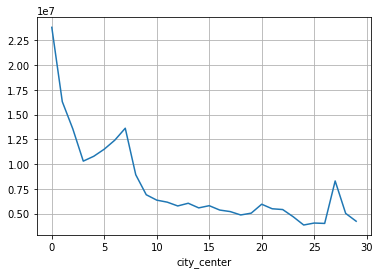

In [122]:
pit_avg.plot(x ='city_center', y = 'last_price', grid = True)

As the distance from the center increases, the cost of apartments drops noticeably. 

### Conclusion

We have conducted a study that assesses the dependence of the price of an apartment in St. Petersburg on such parameters as area, number of storeys, location and date of placement of the advertisement.

We set several tasks and hypotheses:

Task 1 - find out how many days an ad for sale hangs on average.
Task 2 - calculate the price per square meter.
Hypothesis 1 - the influence of the floor space on the price.
Hypothesis 2 - the influence of the floor on the price.
Hypothesis 3 - the effect of the date of placement of the ad on the price.
Hypothesis 4 - the effect of roominess on the price.



<b><u>Task 1 - Completed.</u></b>
The average value for the duration of the ad is 46 - 50 days. Values ​​above fall into the long term group.

<b><u>Task 2 - Partially completed.</u></b>
The price per square meter for each settlement is calculated. However, due to an error, it was not possible to calculate the average price of one square meter in 10 settlements with the largest number of ads.

<b><u>Hypothesis 1 - Confirmed.</u></b>
The average value for squares in St. Petersburg is 52 sq.m. - total, 30 sq.m. - residential and 9 sq.m. - kitchen.
In the work, the area was divided into 3 groups - common, residential and kitchen.
The total area has the greatest impact on the price - as the area increases, the price increases and vice versa.
Living space also has a direct impact on price.
Kitchen area has a minimal direct impact on the price of an apartment.

<b><u>Hypothesis 2 - Confirmed.</u></b>
Based on the results, it can be said that the floor has no effect on the price.
Average number of storeys - 3-4 floor.

<b><u>Hypothesis 3 - Confirmed.</u></b>
The date of placement also does not play a role in the price segment. The most significant for the price was the year the ad was placed.

<b><u>Hypothesis 4 - Confirmed.</u></b>
The main part of the ads consists of 2-room apartments, but the number of rooms also does not affect the price.


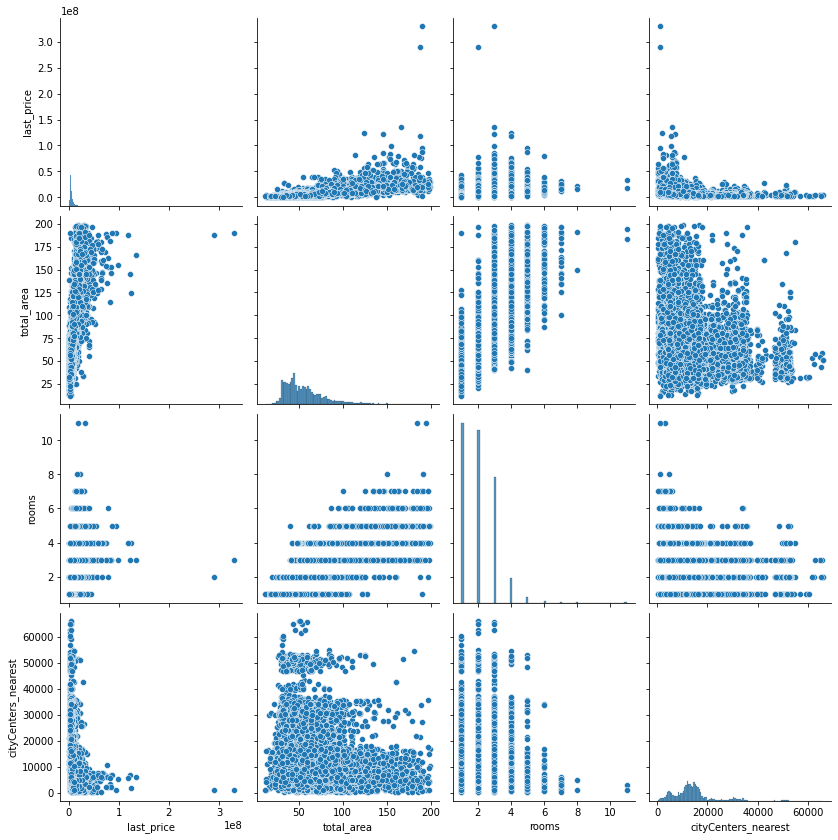

In [124]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


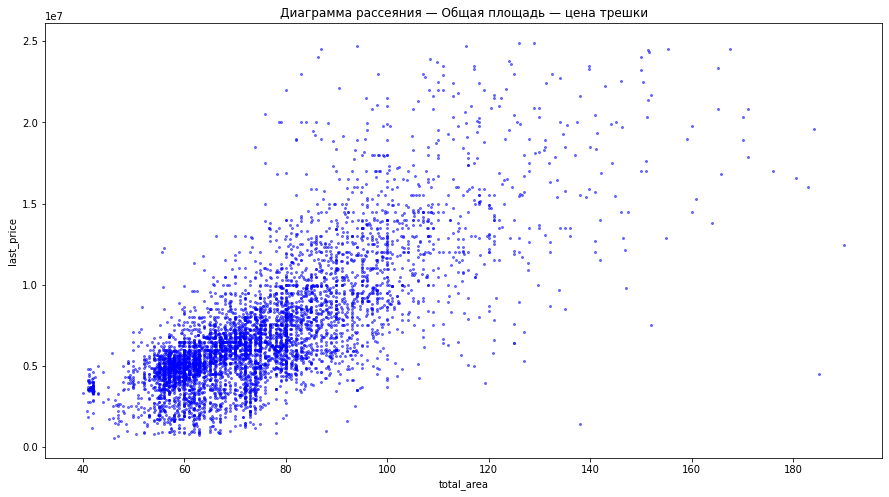

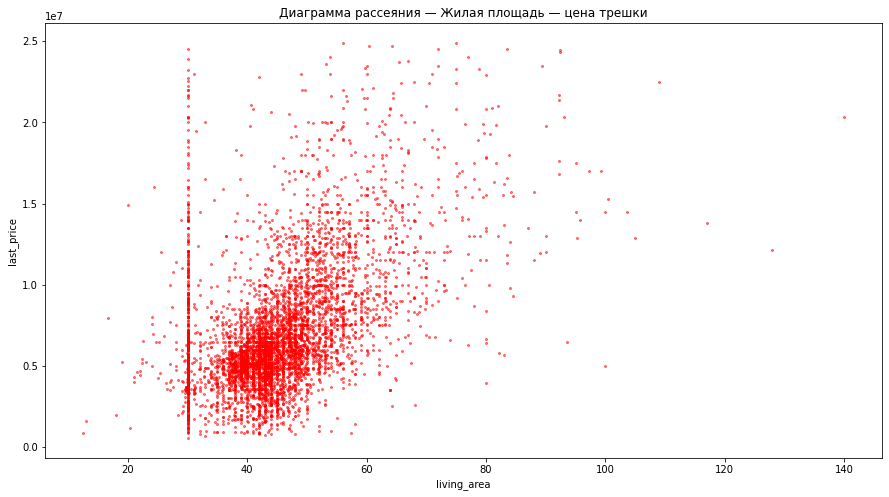

In [125]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

Our synthetic data is clearly visible, we can conclude that the algorithm is not organic and will cause anomalies in statistics and other calculations.

In [126]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check.query('airports_nearest.isna() | airports_nearest < 60000')
df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [127]:
# check
df_check = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
df_check.info()
df_isna = df_check[(df_check ['airports_nearest'] < 60000) | (df_check ['airports_nearest'].isna()) ]

df_isna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<AxesSubplot:>

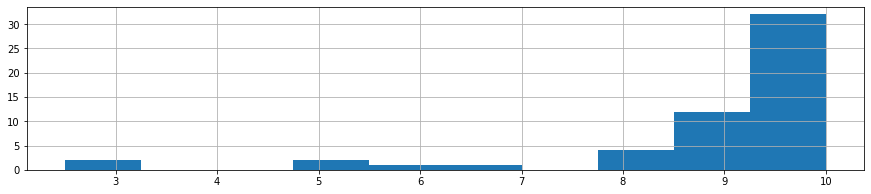

In [128]:
data.living_area.hist(figsize = (15, 3), range = (2.5, 10))